## Importing libaries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import pickle
import numpy as np
from fastai.vision import *
from fastai.callbacks.hooks import *
import matplotlib.pyplot as plt
from lshash import LSHash
from PIL import Image
from tqdm import tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 500)

In [3]:
import sys
# Ensure tatrec package is in the path
sys.path.append(os.path.join(Path.cwd(), "..", "tatrec"))

In [5]:
from tatrec.notebook_funcs import (get_data_from_folder, print_data_classes_size, 
                                   plot_similar_tats_idx)
from tatrec.config import (path_models, path_train_chicago, path_train_cnn, 
                           path_data_clean, path_models_chicago, path_cleaned_chicago)

In [6]:
bs = 128   # batch size
arch = models.resnet50

## Loading Data and Model

In [6]:
tfms = get_transforms(flip_vert = False)

In [7]:
# Use same dataset used to train the model originally
data = get_data_from_folder(path_train_cnn, bs, 64, tfms)

In [8]:
learn = cnn_learner(data, arch, metrics=error_rate)

In [ ]:
learn.load(path_models / "tatrec-stage-2-1")

In [ ]:
data = get_data_from_folder(path_train_chicago, bs, 64, tfms)
learn.data = data
learn.purge()

In [11]:
print_data_classes_size(data)

Number of classes 134
['absider', 'adamfox', 'adrian_montoya_tattooer_312', 'always.jd', 'ames32', 'anthony_jolon', 'archeravecaesar', 'ashleywolly', 'beatdown', 'benart13', 'bobbyearly', 'bobhaasetattooer', 'bonepainter', 'brianbuchak', 'brionestatu', 'caitlindrakemckay', 'caromansur', 'catsgethigh', 'chchtattoos', 'chicagoinktattoo', 'chipdouglastattoo', 'chitotena', 'chrisrodas', 'christattoosstuff', 'closmontilla', 'davidjosephklinetattoos', 'dctattooexpo', 'dead_irene', 'deluxetattoochicago', 'dianaregalado', 'dminus12', 'donmeatball', 'donnaklein', 'drewtattoo13', 'dub_art', 'eldirtylou', 'electric_rat', 'electrictattoo', 'elkeros', 'enniolopez1', 'erik_gillespie', 'erisqesari', 'eternalink', 'flompflomp', 'futureteller', 'gentlemanjoel', 'greatlakestattoo', 'h2oceanloyalty', 'hammerheadtattoo', 'hannahsteeleart', 'hdz.ink', 'heathrave', 'high.onart', 'horifong', 'inkhartreg', 'inkharttattoos', 'insightoceanside', 'insightstudios', 'intenzetattooink', 'jacobkearney', 'jameseastwo

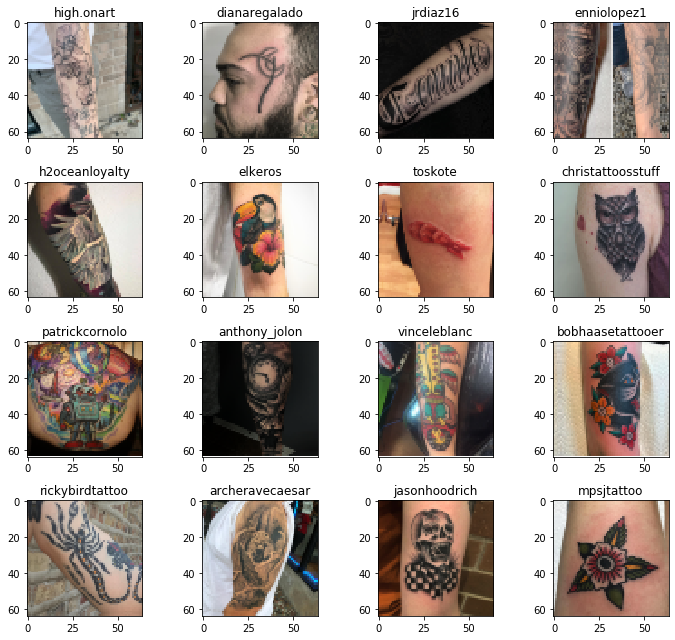

In [12]:
## Show sample data
data.show_batch(rows=4, figsize=(10,9), hide_axis=False) 

## Extracting Feature

Creating a hook right after convolutional part of resnet 50 and max pooling layer which generates a 4096 length vector for a particular image of 256*256.

In [13]:
# this is a hook (used for saving intermediate computations)
# used to extract before the last FC layer for use in similarity matching
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()
        
sf = SaveFeatures(learn.model[1][5]) ## Output before the last FC layer

Creating Feature Vector

In [14]:
# By running this feature vectors would be saved in sf variable initated above
preds = learn.get_preds(data.train_ds)[0]

In [32]:
# Shows the percentage of tattoos that are recognized as not a tattoo
print((1 - len(np.where(preds[:,1] < 0.5)))/len(preds))

0.0


Converting in a dictionary of {img_path:featurevector}

In [17]:
img_path = [str(x) for x in (list(data.train_ds.items))]
feature_dict = dict(zip(img_path,sf.features))

In [18]:
## Exporting as pickle
pickle.dump(feature_dict, open(path_cleaned_chicago/"feature_dict.pkl", "wb"))

## Using Locality Sensitive hashing to find near similar images

In [24]:
## Loading Feature dictionary
feature_dict = pickle.load(open(path_cleaned_chicago/"feature_dict.pkl",'rb'))

In [25]:
## Locality Sensitive Hashing
# params
k = 30 # hash size
L = 5  # number of tables
d = 512 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# LSH on all the images
for img_path, vec in tqdm_notebook(feature_dict.items()):
    lsh.index(vec.flatten(), extra_data=img_path)

In [26]:
## Exporting as pickle
pickle.dump(lsh, open(path_models_chicago/'lsh.pkl', "wb"))

## Visualizing Output

In [6]:
## Loading Feature and lsh dictionaries
feature_dict = pickle.load(open(path_cleaned_chicago/'feature_dict.pkl','rb'))
lsh = pickle.load(open(path_models_chicago/'lsh.pkl','rb'))

In [7]:
extract_item = 438

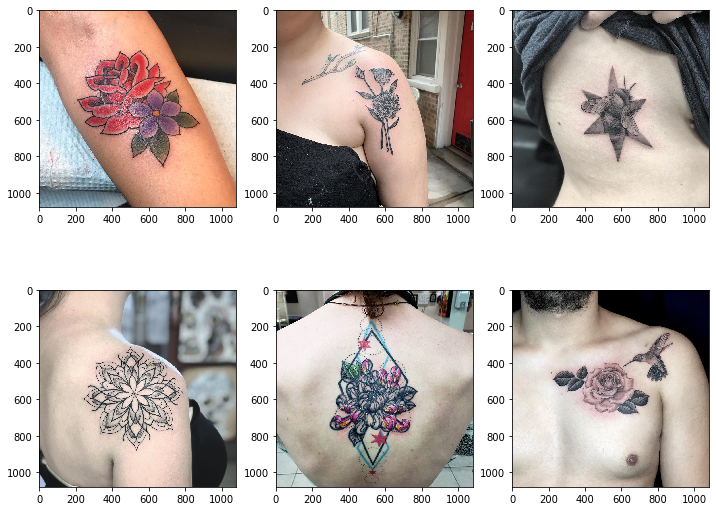

In [8]:
# First image is input and 5 closest similarity matches following
plot_similar_tats_idx(extract_item, feature_dict, lsh, 5)